<a href="https://colab.research.google.com/github/450586509/reinforcement-learning-practice/blob/master/08_rl_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 名字生成

利用rnn生成变量名，或者人名

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

训练数据：
8k个拉丁文名字的训练数据。这种起名方法可以用到其它类似的场景，比如标题生成；游戏名称。

In [0]:
import os
start_token = " "
# 数据来源于：https://github.com/yandexdataschool/Practical_RL/tree/master/week07_%5Brecap%5D_rnn/names
with open("names") as f:
    lines = f.read()[:-1].split('\n')
    lines = [start_token + name for name in lines]

In [22]:
lines[-3:-1]

[' Rahul', ' Shumeet']

max length = 16


(array([1.900e+01, 2.720e+02, 0.000e+00, 9.260e+02, 0.000e+00, 1.878e+03,
        0.000e+00, 2.049e+03, 0.000e+00, 1.447e+03, 0.000e+00, 8.460e+02,
        0.000e+00, 3.510e+02, 0.000e+00, 1.160e+02, 0.000e+00, 2.400e+01,
        0.000e+00, 1.000e+01, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00]),
 array([ 3.  ,  3.52,  4.04,  4.56,  5.08,  5.6 ,  6.12,  6.64,  7.16,
         7.68,  8.2 ,  8.72,  9.24,  9.76, 10.28, 10.8 , 11.32, 11.84,
        12.36, 12.88, 13.4 , 13.92, 14.44, 14.96, 15.48, 16.  ]),
 <a list of 25 Patch objects>)

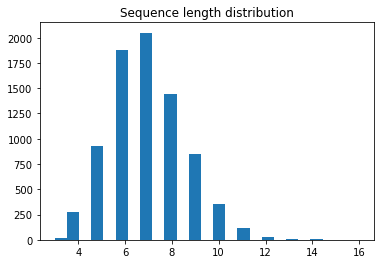

In [23]:

MAX_LENGTH = max(map(len, lines))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)), bins=25)

### 文本预处理
生成字典

In [24]:
tokens = set()
tokens.update("".join(lines))

tokens = list(tokens)

n_tokens = len(tokens)
print('n_tokens = ', n_tokens)

assert 50 < n_tokens < 60

n_tokens =  55


In [25]:
token_to_id = dict([(v,i) for i,v in enumerate(tokens)])
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"
print("Seems alright!")

Seems alright!


In [0]:
def to_matrix(names, max_len=None, pad=token_to_id[' '], dtype='int32'):
    """Casts a list of names into rnn-digestable matrix"""
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

### 实现rnn


In [0]:
import tensorflow as tf
import keras
import keras.layers as L
%tensorflow_version 1.x
emb_size, rnn_size = 16, 64

#embedding 层
embed_x = L.Embedding(n_tokens, emb_size)

# 全连接层，将当前步的input和上一个hidden state,转换为下一个hidden state
get_h_next = L.Dense(rnn_size, activation='tanh')

# a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
get_probas = L.Dense(n_tokens, activation='softmax')

In [0]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces next state and output
    given prev input and previous state.
    We'll call this method repeatedly to produce the whole sequence.
    :param x_t: token vector, int32[batch_size,]
    :param h_t: previous state matrix, float32[batch_size, rnn_size]

    Follow isntructions to complete the function.
    """
    # 1. convert character id into embedding (use embed_x layer)
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]

    # 2. concatenate x _embedding_ and previous h state (over last axis)
    #<YOUR CODE >
    input_h = tf.concat([x_t_emb, h_t], axis=-1)

    # 3. compute next state given h and x embedding
    #<YOUR CODE >
    next_h = get_h_next(input_h)

    # 4. get probabilities for language model P(x_next | h_next)
    #<YOUR CODE >
    next_probas = get_probas(next_h)

    return next_h, next_probas

In [0]:
input_sequence = tf.placeholder('int32', (None, MAX_LENGTH))
batch_size = tf.shape(input_sequence)[0]

# initial hidden state
h0 = tf.zeros([batch_size, rnn_size])

In [30]:

# TEST: single rnn step
h1, p_y1 = rnn_one_step(input_sequence[:, 0], h0)

dummy_data = np.arange(MAX_LENGTH * 2).reshape([2, -1])
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
test_h1, test_p_y1 = sess.run([h1, p_y1],  {input_sequence: dummy_data})

assert test_h1.shape == (len(dummy_data), rnn_size)
assert test_p_y1.shape == (
    len(dummy_data), n_tokens) and np.allclose(test_p_y1.sum(-1), 1)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


rnn loop

In [0]:
h_prev = h0
predicted_probas = []

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]

    # Task: compute next token probas and next hidden state
    h_next, probas_next = rnn_one_step(x_t, h_prev)

    # END OF YOUR CODE

    predicted_probas.append(probas_next)
    h_prev = h_next

predicted_probas = tf.stack(predicted_probas, axis=1)


In [0]:
assert predicted_probas.shape.as_list() == [None, MAX_LENGTH, n_tokens]
assert h_prev.shape.as_list() == h0.shape.as_list()

loss 

In [36]:
predictions_matrix = predicted_probas[:, :-1]
answers_matrix = tf.one_hot(input_sequence[:, 1:], n_tokens)

print('predictions_matrix:', predictions_matrix.shape)
print('answers_matrix:', predictions_matrix.shape)

loss_step = tf.nn.softmax_cross_entropy_with_logits(logits=predictions_matrix, labels=answers_matrix)
loss_step = tf.reduce_mean(loss_step, axis=-1)
loss = tf.reduce_sum(loss_step)
optimize = tf.train.AdamOptimizer().minimize(loss)

predictions_matrix: (?, 15, 55)
answers_matrix: (?, 15, 55)


训练

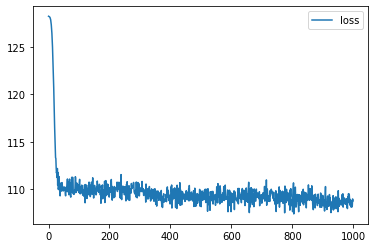

In [37]:
from IPython.display import clear_output
from random import sample
sess.run(tf.global_variables_initializer())

history = []

for i in range(1000):
    batch = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)

    loss_i, _ = sess.run([loss, optimize], {input_sequence: batch})

    history.append(loss_i)
    if (i+1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."